# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 0. Clean Up the Zombie Processes
At the end of this notebook, when you execute `env.close()`, it does not clean up the environment completely. Instead, the Unity environment process becomes a "zombie" process. A zombie process is one that has completed execution but still has an entry in the process table because its parent process hasn’t properly reaped it.
You can yourself verify this by running these commands in the terminal. Find the parent process ID (PPID) of the zombie process:
```bash
ps -o pid,ppid,stat,cmd | grep Reacher
```
If the parent process (PPID) is not 1, kill it to clean up the zombie process:
```bash
kill -9 <PPID>
```
Below is the equivalent Python code that checks for and cleans zombie processes using `psutil`. **You need run the cell below only when you restart the Unity environment.** 

> **NOTE**: The code cell below will also kill the Kernel. You should restart it when required.

In [1]:
import psutil #Library for get information about the operational system process

#Function that detects if there is a process called "Reacher_One_lin" and terminate its parent process.
def cleanup_zombie_processes():
    for proc in psutil.process_iter(['pid', 'ppid', 'name', 'status']):
        if proc.info['name'] == 'Reacher_One_Lin' and proc.info['status'] == 'zombie':
            print(f"Zombie process detected: {proc.info}")
            parent = psutil.Process(proc.info['ppid'])
            print(f"Terminating parent process: {parent}")
            parent.terminate()

cleanup_zombie_processes()

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install . #Install all the libraries in the requirements.txt

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment # Import the Unity package to interact with the Unity ML environment
import numpy as np # Import numpy for numerical computations and matrix operations
import torch # Import PyTorch, a deep learning library, for building and training neural networks
from collections import deque # Import deque from collections to efficiently implement the replay buffer for experience replay
import matplotlib.pyplot as plt # Import matplotlib to visualize training progress and results through graphs
%matplotlib inline

#selecting the device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# select this option to load version 1 (with a single agent) of the Reacher environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

Found path: /data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64
Mono path[0] = '/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis_Data/Managed'
Mono config path = '/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/student/.config/unity3d/Unity Technologies/Unity Environment/Player.log


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain (the only one available in this environment)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size #Size = 4, corresponding to torque applicable to two joints of the arm.
print('Size of each action:', action_size) 

# examine the state space 
states = env_info.vector_observations 
state_size = states.shape[1] ##33 variables corresponding to position, rotation, velocity, and angular velocities of the arm.
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


When finished, you can close the environment.

In [6]:
#env.close()
#This line is comented is order to not close the environment before the new implementation below.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
import torch #imports the deep learning library
import torch.nn as nn #with torch.nn is possible to build the neural network with the desired architecture. 
import torch.nn.functional as F #torch.nn.functional constains the activation functions for the neural networks

#This function defines an initialization range for the weights based on the number of inputs (fan_in).
#This helps maintain training stability by preventing gradients from becoming too large or too small.
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


# The Actor class takes the environment's state as input and outputs the action the agent should take.  
# It is a fully connected neural network with an architecture of 33x128x64x4 (input layer, two hidden layers, and output layer).  
# This architecture was selected through trial and error, as it consistently yielded the best performance. 
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    #Reset the parametes with the defined initializationrange.
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    
    #Perform the forward pass of the network. ReLu is the activaction function beacuse the action values must be in between -1 and 1.
    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


# The critic class takes the environment's state as input and outputs the action value, in order to estimate the quality of the action taken bt the agent.  
# It is a fully connected neural network with an architecture of 33x128x64x4 (input layer, two hidden layers, and output layer).  
# This architecture was selected through trial and error, as it consistently yielded the best performance (equal to the Actor).
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    
# The Q-value can take any real number, so no activation function is applied in the final layer.  
    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [8]:
import numpy as np  # Import NumPy for numerical operations and array manipulation
import random  # Import the random module for generating random numbers
import copy  # Import the copy module to create independent copies of objects
from collections import namedtuple, deque  # Import namedtuple for structured data storage and deque for efficient queue operations

import torch  # Import PyTorch for tensor operations and deep learning functionalities
import torch.nn.functional as F  # Import functional module for activation functions and loss functions
import torch.optim as optim  # Import optim module for optimization algorithms (e.g., Adam, SGD)

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

#selecting the device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size #33
        self.action_size = action_size #4
        self.seed = random.seed(random_seed)

        # Actor network with a target network to stabilize training  
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)  # Main actor network (used for action selection)  
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)  # Target actor network (used for updating the main network)  
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)  # Adam optimizer for updating the actor network  

        # Critic network with a target network to stabilize training
        self.critic_local = Critic(state_size, action_size, random_seed).to(device) # Main actor network (used for action selection)  
        self.critic_target = Critic(state_size, action_size, random_seed).to(device) # Target actor network (used for updating the main network)  
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY) # Adam optimizer for updating the actor network  

        # Noise process (Ornstein-Uhlenbeck)
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)
    
    
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device) #Converts the state to a torch tensor.
        self.actor_local.eval() #Sets the network to evaluation mode (no training)
        with torch.no_grad(): 
            action = self.actor_local(state).cpu().data.numpy() #Returns the action
        self.actor_local.train() #Sets the network back to training mode
        if add_noise:
            action += self.noise.sample() #Adds Ornstein-Uhlenbeck noise for exploration.
        return np.clip(action, -1, 1) #Clip the result in between -1 and 1.
    
    #Resets the noise.
    def reset(self):
        self.noise.reset() 
    
    #Updates the local and target networks of the Actor and Critic with the batch of experiences.
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    # Updates the target network gradually using soft updates at each iteration.
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

#Defines the Ornstein-Uhlenbeck noise.
class OUNoise:
    """Ornstein-Uhlenbeck process.
    It is a type of temporally correlated noise commonly used in reinforcement learning (RL), 
    particularly for training neural networks in continuous action spaces.
    It is often used in algorithms like Deep Deterministic Policy Gradient (DDPG)
    to encourage exploration in deterministic policies."""
    
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2, sigma_min=0.05, decay=0.99):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.sigma_min = sigma_min #Sigma's lower bound.
        self.decay = decay #Decay rate
        random.seed(seed)
        np.random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state to mean (mu)."""
        self.state = np.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.normal(size=len(x))
        self.state = x + dx
        return self.state

    def decay_noise(self):
        """Reduce the noise over time."""
        self.sigma = max(self.sigma * self.decay, self.sigma_min)

#implements the Replay Buffer.
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        #Converts the numpy arrays into torch tensors.
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [9]:
#Initializing the agent.
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1234)

Episode 100	Average Score: 2.85
Episode 200	Average Score: 9.98
Episode 300	Average Score: 22.75
Episode 339	Average Score: 29.99
Episode 340	Average Score: 30.13
Success! Environment solved!


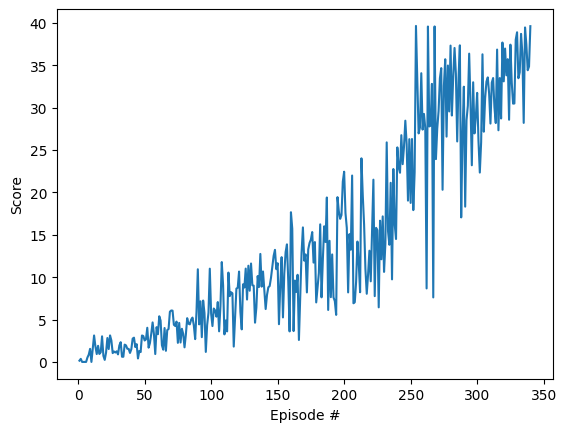

In [10]:
#Deep Deterministic Policy Gradient
def ddpg(n_episodes=1000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every) #To save the scores in each episode.
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # Reset environment and get initial state
        state = env_info.vector_observations               # Extract the state
        agent.reset()                                      # Reset the agent
        agent.noise.decay_noise()                          # Reduce exploration
        score = np.zeros(num_agents)                       # Initialize score for each agent (1 in this environment)
        for t in range(max_t):                             # Begin the trajectory until max_t steps or done condition.
            action = agent.act(state)                      # Select the action given the environment
            env_info = env.step(action)[brain_name]        # Send action to environment
            next_state = env_info.vector_observations      # Get next state
            reward = env_info.rewards                      # Get reward
            done = env_info.local_done                     # Check if episode is done
            agent.step(state, action, reward, next_state, done) #If there is enough experience in the replay buffer, learn from it.
            state = next_state                             #Update the state
            score += reward                                # Accumulate rewards for each agent
            if np.any(done):                               # Exit loop if episode is done
                break 
        scores_deque.append(np.mean(score))                # Append average score
        scores.append(np.mean(score))
        
        if len(scores) >= 100:
            avg_score = np.mean(scores[-100:])             # Calculate the average score of the last 100 episodes
            if avg_score > 30:                             #If the avergare score for the last 100 episodes is greater than 30, the environment is solved.
                print(f'\nEpisode {i_episode}\tAverage Score: {avg_score:.2f}\nSuccess! Environment solved!')
                break
        
        #Save the weights of the Actor and Critic
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_deque):.2f}', end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_deque):.2f}')
            
    return scores

#Initialize the DDPG algorithm.
scores = ddpg()

#Plot the average scores.
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()